# Time Series Analysis Using Regression

In this notebook I am going to look through a single example on predicting a time series forecast using regression methods. These methods are the same to the regression methods that we saw earlier in the course when looking at predicing a dependant variable such as house price from independant variables such as number of bedrooms and area of the city. However in the case of time series data we are going to look at how other variables can be used to help predict a forecast. These variables are know as **exogeneous variables**

## <a id='1'> **Package and Data Import** </a>

### Import Packages

As usual, one of the first steps is to import the libraries we'll need throughout the analysis.

In [1]:
## Import packages
import pandas as pd               # Used to work with tables in Python
import numpy as np                # Used to work with arrays and Pandas Series (columns)
import matplotlib.pyplot as plt   # A useful visualisation package
import seaborn as sns             # Another useful visualisation package
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

C:\Users\PeterBaksh\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\PeterBaksh\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\PeterBaksh\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\PeterBaksh\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Get the Data

We are going to work with some data that has already been cleaned for us to make this notebook nice and short and to the point. The data is looking at energy demand for a city in spain over time. We have infomation on the data/ time and the energy demand on the city as well as the temperature

In [2]:
df = pd.read_csv('https://github.com/DrPBaksh/workshop-data/blob/main/temperature_load.csv?raw=true')
df.head()

,date_time,total load actual,temp_mean,date,time
0,2015-01-01 00:00:00,25385.0,270.475,2015-01-01,00:00:00
1,2015-01-01 01:00:00,24382.0,270.475,2015-01-01,01:00:00
2,2015-01-01 02:00:00,22734.0,269.686,2015-01-01,02:00:00
3,2015-01-01 03:00:00,21286.0,269.686,2015-01-01,03:00:00
4,2015-01-01 04:00:00,20264.0,269.686,2015-01-01,04:00:00


## <a id='1'> **Clean Data and any EDA** </a>

THis data is mostly clean so this wont be comprehensive here

This is a personal preference. I am going to rename the total load actual to a single word so it is easier to call in the rest of this analysis

In [3]:
df.rename(columns = {'total load actual' : 'load'}, inplace =  True)

It is always a good idea to plot your data in order to see what the time series looks like. In a more comprehensive notebook you should check the statisitics of your data / missing values in the **EDA** phase however to keep this notebook focused on using *regression* for time series forecasting we shall keep this light touch. 

When I first went to plot this it gave a horrible line graph that made no sense. This was because python had not recognised the date_time column as a date. We are going to set that column as a date and also look to make it an index for now

In [4]:
df['date_time'] = pd.to_datetime(df.date_time)
df.set_index('date_time', inplace = True)

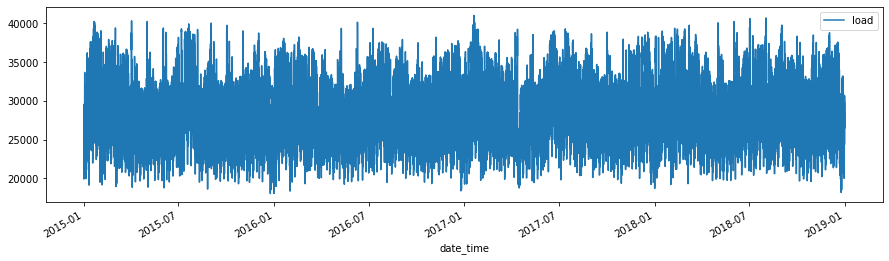

In [5]:
df.plot(y = 'load')
fig = plt.gcf()

fig.set_size_inches(15, 4)

This is showing all the data lets have a look at just the last year

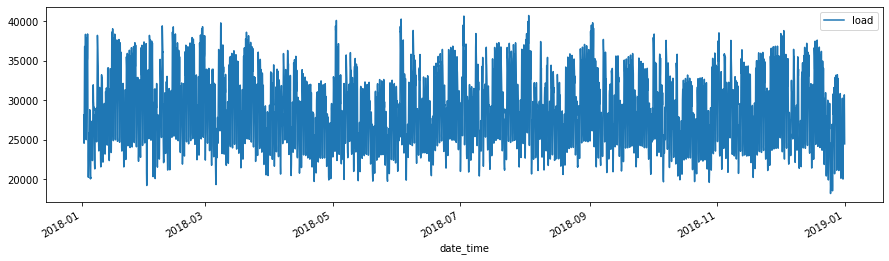

In [6]:
df.query('date > "2018-01-01"').plot( y = 'load')
fig = plt.gcf()
fig.set_size_inches(15, 4)


We can see some more detail but still not enough . Lets go to just one month

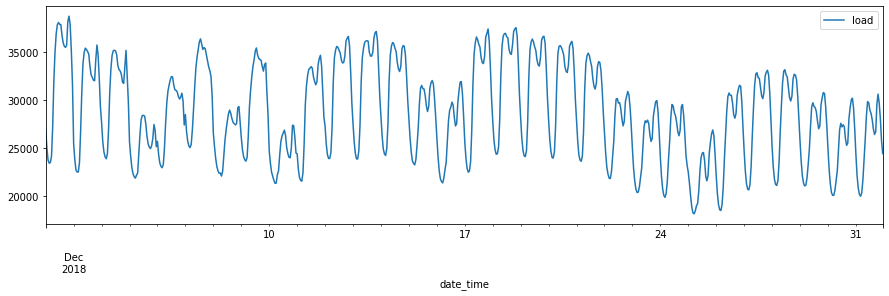

In [7]:
df.iloc[int(24*30)*-1 :].plot( y = 'load')
fig = plt.gcf()
fig.set_size_inches(15, 4)


Now we can see the repeating pattern in energy demand that looks to fluctaute every day and then every week there is a pattern and in the longer term period there looks to be fluctuation throughout the year. 



### What could be influencing our actual load

- In our dataset we have the temperature. This could be. When considering your problem features external to the time series could definitly be used as a factor to help predict your time series
- Time of day : We are seeing fluctuations within a 24 hour period. This is telling us we need to include time of day in a regression forecast
- Day of the week: There looks to be fluctuations in demand depending on the day of the week. If this is the case we need to include this as a feature in our predictin
- Month of the year : Does the data look to be changing depending on Month? It looks like it is. If we are unsure we can group the data by month and have a look at this?
- Year : Is the data changing year by year. If it is this needs to be a feature that we can include in our regression analysis. 

##### Other variables to consider
- lag variables : These are variables that we can create based on, in this case, averages of the load over a period prior to the forecast. These can sometimes be influencial in forecasting
- Holiday specific dates : National holidays  are good candidates for these. Depending on the problem there could be other dates around the year that could be included in a regression analysis. For example prediciting holiday bookings will not just be dependant on the seasonal date however there will be a large influence on the school holidays. Having a column that lets the algorithm know if this date is a school holiday or not is likely to improve your forecast signficantly. 

### Basic model - Single variable 
- The first model we shall create is a linear regression model based on predicting the load given the temperature. 

## <a id='1'> **Prepare data for ML** </a>

#### Train test split

- As with all machine learning problems we need to generate our training and our testing data
- We are just going to use one testing split. 
- Note sklearn does provide a more robust method for train test split on time series data that takes multiple folds in time . Infomation on this can be found in the following links. https://medium.com/keita-starts-data-science/time-series-split-with-scikit-learn-74f5be38489e . https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html



In [8]:
thresh = 0.95 #  95 % of the data used for training
y = df['load']
X = df.iloc[:, [1]]
X_train = X.iloc[:int(len(X) * thresh), :]
X_test = X.iloc[int(len(X) * thresh):, :]
y_train = y[:int(len(X) * thresh)]
y_test = y[int(len(X) * thresh):]

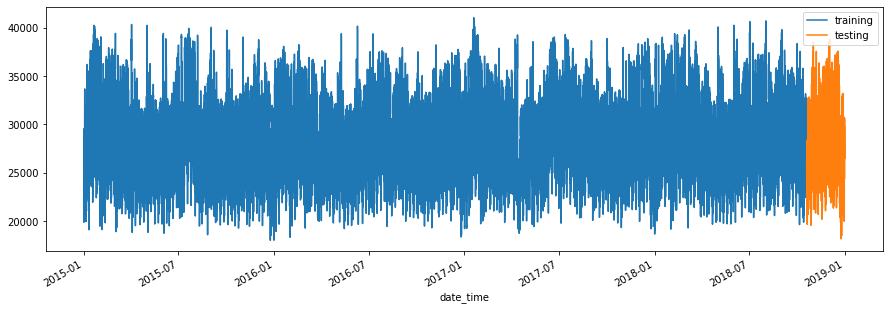

In [9]:
fig = plt.figure(figsize=(15, 5))
y_train.plot(y = 'load')
y_test.plot(y = 'load')
plt.legend(['training', 'testing'])

## <a id='1'> **Model Building** </a>
The first model we shall use is a linear regression model that we have already seen. First lets look at a reg plot to see whats going on

C:\Users\PeterBaksh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


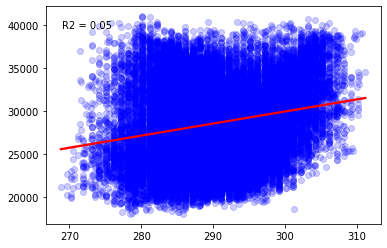

In [10]:
from scipy import stats
sns.regplot(X_train.temp_mean.values, y_train.values, color='red', scatter_kws={'color': 'blue', 'alpha': 0.2})
x = X_train.temp_mean.values
y = y_train.values
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
r_squared = r_value ** 2
plt.annotate(f'R2 = {r_squared:.2f}', xy=(0.05, 0.9), xycoords='axes fraction')

# display plot
plt.show()

There looks to be a positive correlation however a large amount of fluctuation hence the low R2. However lets still see what a regression model using LR does

In [11]:
model = sm.OLS(y_train, sm.add_constant(X_train.values),missing='raise').fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   load   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     1749.
Date:                Mon, 27 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:34:35   Log-Likelihood:            -3.2711e+05
No. Observations:               33310   AIC:                         6.542e+05
Df Residuals:                   33308   BIC:                         6.542e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.221e+04    978.145    -12.486      0.000   -1.41e+04   -1.03e+04
x1           140.5357      3.360     41.826      0.000     133.950     147.121
==============================================================================
Omnibus:                     2400.622   Durbin-Watson:                   0.100
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              951.071
Skew:                           0.175   Prob(JB):                    3.00e-207
Kurtosis:                       2.250   Cond. No.                     1.17e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## <a id='1'> **Stage 5. Model Evaluation** </a>

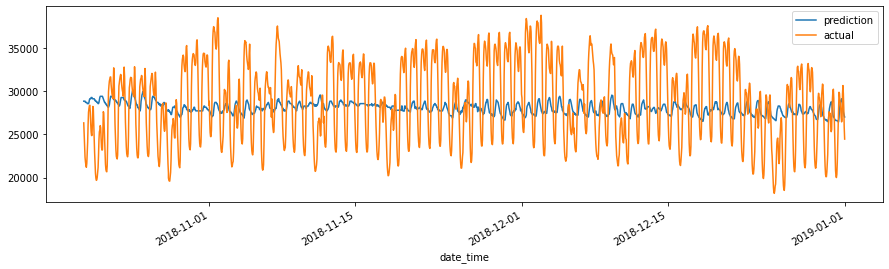

In [12]:
predictions= model.predict(sm.add_constant(X_test))
predictions.plot()
y_test.plot()
plt.legend(['prediction', 'actual'])
fig = plt.gcf()
fig.set_size_inches(15,4)

By eye it looks like this model can capture some fluctuation per day. However it can not capture the magnitude of change in the data. We should look into quantitive metrics at this point

### Evaluation Metrics

Lets make some basic evaluation metrics for these forecasts. For today lets use the Mean Average Percentage Error, residuals and the standard error



In [13]:
import numpy as np
def MAPE (x, y):
    pe_store = []
    for x , y in zip(x, y):
        pe = 100 * np.abs((x- y) / y)
        
        pe_store.append(pe)
    return np.mean(pe_store), pe_store

def standard_error(x, y):
    error = []
    for x , y in zip(x, y):
        error.append(np.abs((x- y)))
    return np.mean(error), error    

def resid(x, y):
    error = []
    for x , y in zip(x, y):
        error.append(((x- y)))
    return  error   

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_forecast(y_pred, y_true):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R2 Score: {r2:.2f}")
    return rmse, mape, r2

Checking the residuals are normally centred. If they are not normally centered then we have some bias in the forecast

<AxesSubplot:ylabel='Count'>

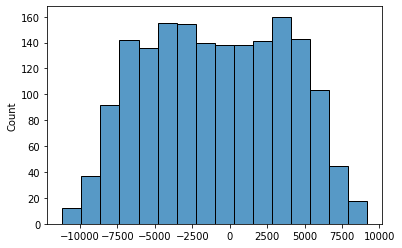

In [14]:
residuals = resid(predictions, y_test)
sns.histplot(residuals, kde=False)

In [15]:
se ,a  = standard_error(predictions, y_test)
print(se)
rmse, mape, r2 = evaluate_forecast(predictions, y_test)
mpae, pe = MAPE(predictions, y_test)


3995.812551426907
RMSE: 4677.20
MAPE: 14.01%
R2 Score: 0.02


Lets start a dataframe to store these results for each experiment. We may also alter the data so we shall keep track of that too

In [16]:
d = {'model': 'LR','training':'Temperature only', 'testing' : 'y_test', 'RMSE' : rmse, 'MAPE': mape, 'R2': r2}
results = pd.DataFrame.from_dict(d, orient='index').T
results

,model,training,testing,RMSE,MAPE,R2
0,LR,Temperature only,y_test,4677.197549,14.007995,0.016588


Below we plot the mean percentage error against the percentage error for each point in the testing data 

Text(0.5, 1.0, 'MAPE = 14.007994619816525')

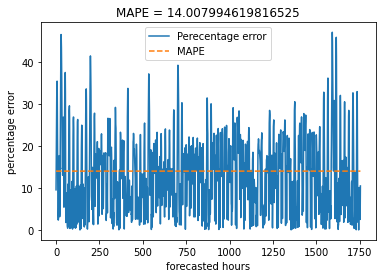

In [17]:


plt.plot(range(len(pe)), pe)
plt.plot(range(len(pe)), [mape] * len(pe), '--')
plt.legend(['Perecentage error', 'MAPE'])
plt.xlabel('forecasted hours')
plt.ylabel('percentage error')
plt.title ('MAPE = ' + str(mape)) 

Finally lets start a results dataframe to store the results themselves

In [18]:
import copy
y_test_predictions = copy.deepcopy(y_test).to_frame()
y_test_predictions['lr_temp_only'] = predictions
y_test_predictions

,load,lr_temp_only
date_time,,
2018-10-19 23:00:00,26331.0,28844.613053
2018-10-20 00:00:00,24963.0,28844.613053
2018-10-20 01:00:00,23395.0,28844.613053
2018-10-20 02:00:00,22347.0,28844.613053
2018-10-20 03:00:00,21799.0,28704.077372
...,...,...
2018-12-31 19:00:00,30653.0,27931.131124
2018-12-31 20:00:00,29735.0,27579.791921
2018-12-31 21:00:00,28071.0,27368.988399


**Now we have a baseline model we can begin to improve this model by creating more datetime features**

This is the key part in using a regression model for time series forecasting

Lets break our date time out into time, day of week, month and year

In [19]:
df['year'] = [df.index[i].year for i in range(len(df))]
df['month'] = [df.index[i].month for i in range(len(df))]
df['time'] = [int(str(df.index[i].time())[0:2]) for i in range(len(df))]
df['dayofweek'] = [df.index[i].weekday() for i in range(len(df))]

In [20]:
df.head()

,load,temp_mean,date,time,year,month,dayofweek
date_time,,,,,,,
2015-01-01 00:00:00,25385.0,270.475,2015-01-01,0,2015,1,3
2015-01-01 01:00:00,24382.0,270.475,2015-01-01,1,2015,1,3
2015-01-01 02:00:00,22734.0,269.686,2015-01-01,2,2015,1,3
2015-01-01 03:00:00,21286.0,269.686,2015-01-01,3,2015,1,3
2015-01-01 04:00:00,20264.0,269.686,2015-01-01,4,2015,1,3


Now we have generated some time features lets fit a a lnear regression using the OLS algorithm. However first we need to redo X_train and y_train

In [21]:
thresh = 0.95 #  95 % of the data used for training
y = df['load']
X = df.iloc[:, [1, 3, 4, 5, 6]]
X_train = X.iloc[:int(len(X) * thresh), :]
X_test = X.iloc[int(len(X) * thresh):, :]
y_train = y[:int(len(X) * thresh)]
y_test = y[int(len(X) * thresh):]

In [22]:
X_train.head()

,temp_mean,time,year,month,dayofweek
date_time,,,,,
2015-01-01 00:00:00,270.475,0,2015,1,3
2015-01-01 01:00:00,270.475,1,2015,1,3
2015-01-01 02:00:00,269.686,2,2015,1,3
2015-01-01 03:00:00,269.686,3,2015,1,3
2015-01-01 04:00:00,269.686,4,2015,1,3


In [23]:
sm.add_constant(X_test).head(1)

,temp_mean,time,year,month,dayofweek
date_time,,,,,
2018-10-19 23:00:00,292.15,23,2018,10,4


In [24]:
model_lr =  sm.OLS(y_train, sm.add_constant(X_train) ,missing='raise').fit()
model_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   load   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     3519.
Date:                Mon, 27 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:34:37   Log-Likelihood:            -3.2090e+05
No. Observations:               33310   AIC:                         6.418e+05
Df Residuals:                   33304   BIC:                         6.419e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.338e+05   3.81e+04     -8.770      0.000   -4.08e+05   -2.59e+05
temp_mean     63.9862      3.071     20.834      0.000      57.967      70.006
time         339.4282      3.051    111.267      0.000     333.449     345.407
year         169.5538     18.941      8.952      0.000     132.429     206.678
month        -98.3775      6.387    -15.403      0.000    -110.896     -85.859
dayofweek   -447.9358     10.131    -44.216      0.000    -467.792    -428.079
==============================================================================
Omnibus:                      577.535   Durbin-Watson:                   0.256
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              502.972
Skew:                           0.244   Prob(JB):                    6.04e-110
Kurtosis:                       2.649   Cond. No.                     3.83e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.83e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R squared is vastly improved after using date time features. Lets view a plot of the prediction and the real data

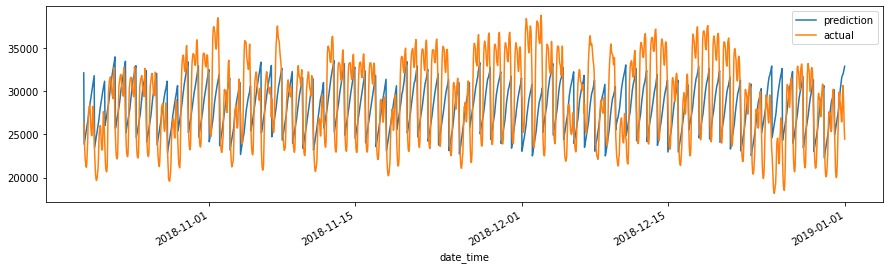

In [25]:
predictions= model_lr.predict(sm.add_constant(X_test,has_constant='add')) # the has_constant is required because there is already a column, month that has 0 variance
predictions.plot()
y_test.plot()
plt.legend(['prediction', 'actual'])
fig = plt.gcf()
fig.set_size_inches(15,4)

Lets make some basic evaluation metrics for these forecasts. For today lets use the Mean Average Percentage Error, residuals and the standard error



Checking the residuals are normally centred. 

<AxesSubplot:ylabel='Count'>

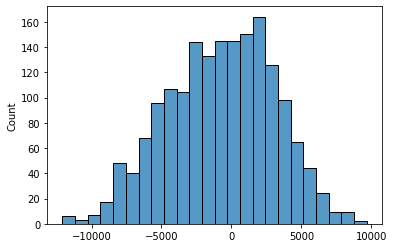

In [26]:
residuals = resid(predictions, y_test)
sns.histplot(residuals, kde=False)

RMSE: 3888.82
MAPE: 10.89%
R2 Score: 0.32


Text(0.5, 1.0, 'MAPE = 10.892792737477683')

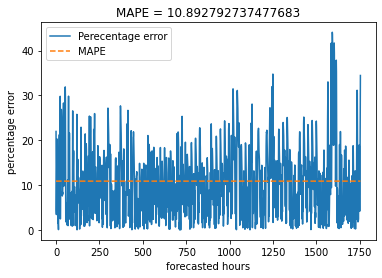

In [27]:
rmse, mape, r2 = evaluate_forecast(predictions, y_test)
mape, pe = MAPE(predictions, y_test)
plt.plot(range(len(pe)), pe)
plt.plot(range(len(pe)), [mape] * len(pe), '--')
plt.legend(['Perecentage error', 'MAPE'])
plt.xlabel('forecasted hours')
plt.ylabel('percentage error')
plt.title ('MAPE = ' + str(mape)) 

Lets add the new results to our results store

In [28]:
d = {'model': 'LR','training':'Temperature plus date features', 'testing' : 'y_test', 'RMSE' : rmse, 'MAPE': mape, 'R2': r2}
results = results.append(d, ignore_index = True)

C:\Users\PeterBaksh\AppData\Local\Temp\ipykernel_20628\3619465808.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index = True)


In [29]:
results

,model,training,testing,RMSE,MAPE,R2
0,LR,Temperature only,y_test,4677.197549,14.007995,0.016588
1,LR,Temperature plus date features,y_test,3888.823495,10.892793,0.32017


In [30]:
y_test_predictions['lr-date_temp'] = predictions
y_test_predictions

,load,lr_temp_only,lr-date_temp
date_time,,,
2018-10-19 23:00:00,26331.0,28844.613053,32115.512704
2018-10-20 00:00:00,24963.0,28844.613053,23860.727388
2018-10-20 01:00:00,23395.0,28844.613053,24200.155626
2018-10-20 02:00:00,22347.0,28844.613053,24539.583865
2018-10-20 03:00:00,21799.0,28704.077372,24815.025865
...,...,...,...
2018-12-31 19:00:00,30653.0,27931.131124,31936.877593
2018-12-31 20:00:00,29735.0,27579.791921,32116.340236
2018-12-31 21:00:00,28071.0,27368.988399,32359.789117


Across the metrics we can see imporvements. Lets look in more detail in how the forecast is behaving over a shorter time period


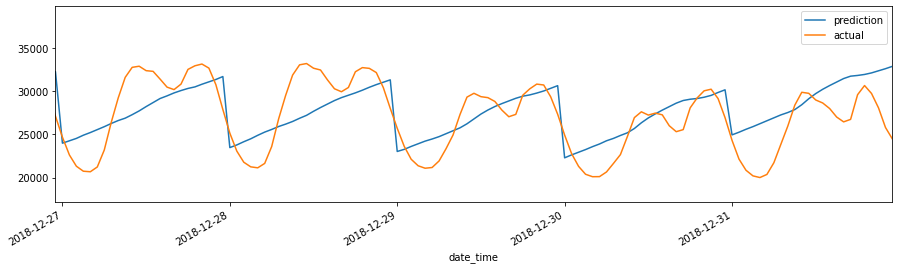

In [31]:
import datetime
predictions= model_lr.predict(sm.add_constant(X_test, has_constant='add'))
predictions.plot()
y_test.plot()
plt.legend(['prediction', 'actual'])
plt.xlim([y_test.index.max() - datetime.timedelta(days = 5), y_test.index.max()])
fig = plt.gcf()
fig.set_size_inches(15,4)

We can see the model does not have the flexibility to seem to fit to the rediction in load that we get at the peak of the day. This could be a limitation of using linear regression for our forecast. As the hour gets larger it does not have non linear behaviour to accomodate for this. However we have other regression methods that have more flexibility to make an imporved prediction

##  <a id='1'> **Stage 6. Imporvement using XGBoost** </a>

*XGBoost (eXtreme Gradient Boosting) is a powerful and popular machine learning algorithm used for regression and classification problems. It is an implementation of gradient boosting framework. Gradient boosting is an ensemble method that combines multiple weak models, typically decision trees, to create a stronger model. XGBoost improves upon the traditional gradient boosting algorithm by using a more regularized model formalization to control over-fitting, which gives it better performance.The algorithm works by iteratively training decision tree models on the negative gradient of the loss function of the previous iteration. The decision tree models are trained using the gradient descent algorithm. The final model is a weighted sum of all the decision tree models.The algorithm also includes a built-in regularization term, which helps to reduce overfitting and improve generalization. This is done by introducing a penalty term for the number of terminal nodes in the trees, which is controlled by a parameter called "gamma".Additionally, XGBoost includes several other features such as parallel processing, handling missing values, built-in cross-validation, and handling categorical variables. It is widely used in many Kaggle competitions and industry applications because of its high performance, speed and scalability.*

Resources about XGBoost regressor
- https://xgboost.readthedocs.io/en/stable/python/python_intro.html
- https://www.youtube.com/watch?v=OtD8wVaFm6E

XGBoost is a very simple algorithm to train and uses the same class structure as scikit learn algroithms


In [32]:
# !pip install xgboost

In [33]:
from xgboost import XGBRegressor
model_xg = XGBRegressor()
model_xg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Just like that the regressor is trained with the default params. As we did with linear regression lets explore the results on the test data

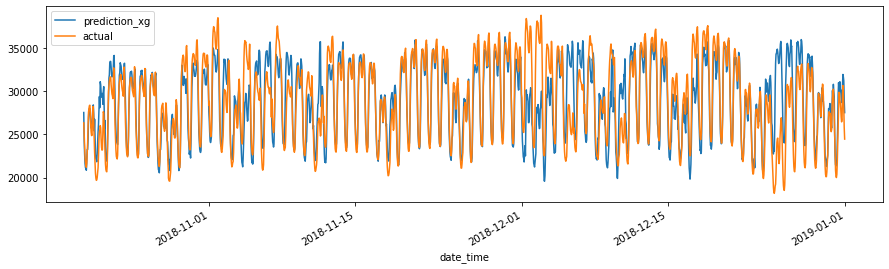

In [34]:
predictions_xg= pd.DataFrame({'xgb' :model_xg.predict(X_test), 'date': y_test.index})
predictions_xg.set_index('date', inplace = True)
predictions_xg.plot()
y_test.plot()
plt.legend(['prediction_xg', 'actual'])
fig = plt.gcf()
fig.set_size_inches(15,4)

<AxesSubplot:ylabel='Count'>

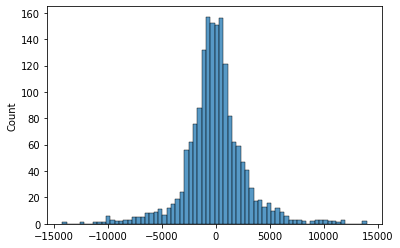

In [35]:
residuals_xg = resid(predictions_xg['xgb'], y_test)
sns.histplot(residuals_xg, kde=False)

RMSE: 2826.04
MAPE: 6.75%
R2 Score: 0.64


Text(0.5, 1.0, 'MAPE = 6.751450865077799')

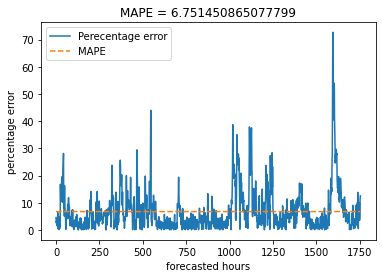

In [36]:
rmse, mape, r2 = evaluate_forecast(predictions_xg['xgb'], y_test)
mape, pe = MAPE(predictions_xg['xgb'], y_test)
plt.plot(range(len(pe)), pe)
plt.plot(range(len(pe)), [mape] * len(pe), '--')
plt.legend(['Perecentage error', 'MAPE'])
plt.xlabel('forecasted hours')
plt.ylabel('percentage error')
plt.title ('MAPE = ' + str(mape)) 

In [37]:
d = {'model': 'XGB','training':'Temperature plus date features', 'testing' : 'y_test', 'RMSE' : rmse, 'MAPE': mape, 'R2': r2}
results = results.append(d, ignore_index = True)

C:\Users\PeterBaksh\AppData\Local\Temp\ipykernel_20628\3958568769.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index = True)


In [38]:
results

,model,training,testing,RMSE,MAPE,R2
0,LR,Temperature only,y_test,4677.197549,14.007995,0.016588
1,LR,Temperature plus date features,y_test,3888.823495,10.892793,0.32017
2,XGB,Temperature plus date features,y_test,2826.03774,6.751451,0.640979


In [39]:
y_test_predictions['xgb_temp_date'] = predictions_xg
y_test_predictions.head(3)

,load,lr_temp_only,lr-date_temp,xgb_temp_date
date_time,,,,
2018-10-19 23:00:00,26331.0,28844.613053,32115.512704,27531.595703
2018-10-20 00:00:00,24963.0,28844.613053,23860.727388,24318.933594
2018-10-20 01:00:00,23395.0,28844.613053,24200.155626,22746.380859


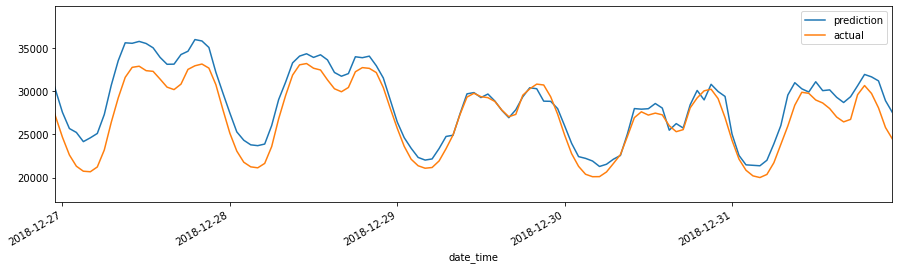

In [40]:
predictions_xg.plot()
y_test.plot()
plt.legend(['prediction', 'actual'])
plt.xlim([y_test.index.max() - datetime.timedelta(days = 5), y_test.index.max()])
fig = plt.gcf()
fig.set_size_inches(15,4)

The XGBoost regressor has showed it has the flexibility to fit the reduction in load that we see during the dat time that linear regression could not do.We can also have a look at the feature importance of the variables used to understand what was most influencial to the forecast 

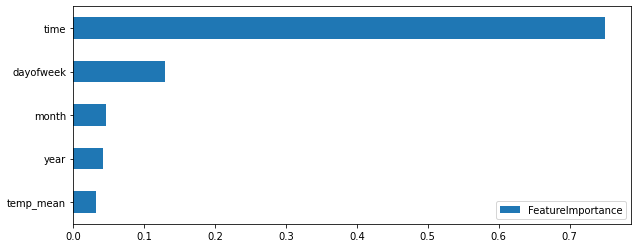

In [41]:
feat_imp_dict = dict(zip(X_train.columns, model_xg.feature_importances_))
feat_imp = pd.DataFrame.from_dict(feat_imp_dict, orient='index')
feat_imp.rename(columns = {0:'FeatureImportance'}, inplace = True)
feat_imp.query('FeatureImportance>0').sort_values(by=['FeatureImportance']).plot.barh();
fig = plt.gcf()
fig.set_size_inches(10, 4)

We can see from this that the time componenet is the most important feature in this forecast.

This notebook has gone through an example of how you could apply a regression in order to make a time series forecast



### Visually Compare our results so far


In [42]:
y_test_predictions

,load,lr_temp_only,lr-date_temp,xgb_temp_date
date_time,,,,
2018-10-19 23:00:00,26331.0,28844.613053,32115.512704,27531.595703
2018-10-20 00:00:00,24963.0,28844.613053,23860.727388,24318.933594
2018-10-20 01:00:00,23395.0,28844.613053,24200.155626,22746.380859
2018-10-20 02:00:00,22347.0,28844.613053,24539.583865,21638.275391
2018-10-20 03:00:00,21799.0,28704.077372,24815.025865,21153.812500
...,...,...,...,...
2018-12-31 19:00:00,30653.0,27931.131124,31936.877593,31937.515625
2018-12-31 20:00:00,29735.0,27579.791921,32116.340236,31656.158203
2018-12-31 21:00:00,28071.0,27368.988399,32359.789117,31191.585938


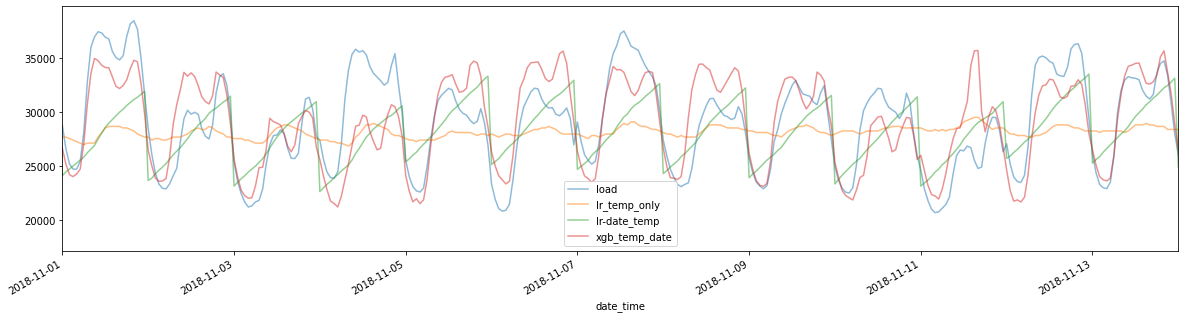

In [43]:
y_test_predictions.plot(figsize = (20, 5), alpha = 0.5)
plt.xlim([pd.to_datetime('2018-11-01'), pd.to_datetime('2018-11-14')])
plt.show()

### XGBoost without Exogenous Variables

The feature importance plot shows that temperature is not actually that important. Lets see how the forecast will do only with datetime features

In [44]:
X_train.drop(columns = ['temp_mean'], inplace = True)
X_test.drop(columns = ['temp_mean'], inplace = True)

C:\Users\PeterBaksh\AppData\Local\Temp\ipykernel_20628\1845816722.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(columns = ['temp_mean'], inplace = True)
C:\Users\PeterBaksh\AppData\Local\Temp\ipykernel_20628\1845816722.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(columns = ['temp_mean'], inplace = True)


In [45]:
X_train.head()

,time,year,month,dayofweek
date_time,,,,
2015-01-01 00:00:00,0,2015,1,3
2015-01-01 01:00:00,1,2015,1,3
2015-01-01 02:00:00,2,2015,1,3
2015-01-01 03:00:00,3,2015,1,3
2015-01-01 04:00:00,4,2015,1,3


In [46]:
from xgboost import XGBRegressor
model_xg = XGBRegressor()
model_xg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

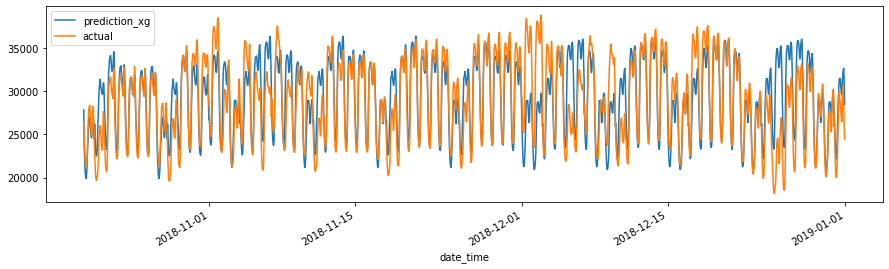

In [47]:
predictions_xg= pd.DataFrame({'xgb' :model_xg.predict(X_test), 'date': y_test.index})
predictions_xg.set_index('date', inplace = True)
predictions_xg.plot()
y_test.plot()
plt.legend(['prediction_xg', 'actual'])
fig = plt.gcf()
fig.set_size_inches(15,4)

RMSE: 2903.25
MAPE: 7.33%
R2 Score: 0.62


Text(0.5, 1.0, 'MAPE = 7.332212678201661')

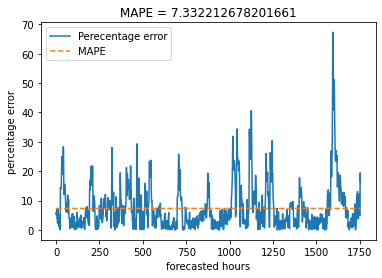

In [48]:
rmse, mape, r2 = evaluate_forecast(predictions_xg['xgb'], y_test)
mape, pe = MAPE(predictions_xg['xgb'], y_test)
predictions_xg['xgb'], y_test
plt.plot(range(len(pe)), pe)
plt.plot(range(len(pe)), [mape] * len(pe), '--')
plt.legend(['Perecentage error', 'MAPE'])
plt.xlabel('forecasted hours')
plt.ylabel('percentage error')
plt.title ('MAPE = ' + str(mape)) 

In [49]:
d = {'model': 'XGB','training':'Date Features Only', 'testing' : 'y_test', 'RMSE' : rmse, 'MAPE': mape, 'R2': r2}
results = results.append(d, ignore_index = True)


C:\Users\PeterBaksh\AppData\Local\Temp\ipykernel_20628\3622588200.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index = True)


In [50]:
results

,model,training,testing,RMSE,MAPE,R2
0,LR,Temperature only,y_test,4677.197549,14.007995,0.016588
1,LR,Temperature plus date features,y_test,3888.823495,10.892793,0.32017
2,XGB,Temperature plus date features,y_test,2826.03774,6.751451,0.640979
3,XGB,Date Features Only,y_test,2903.253274,7.332213,0.621092


In [51]:
y_test_predictions['xgb_date'] = predictions_xg
y_test_predictions.head(3)

,load,lr_temp_only,lr-date_temp,xgb_temp_date,xgb_date
date_time,,,,,
2018-10-19 23:00:00,26331.0,28844.613053,32115.512704,27531.595703,27835.466797
2018-10-20 00:00:00,24963.0,28844.613053,23860.727388,24318.933594,23581.941406
2018-10-20 01:00:00,23395.0,28844.613053,24200.155626,22746.380859,22185.484375


Not bad, given we have based this forecast only on time features however clearly a reduction in R2 given no temperature but not by much

# Extra: Adding weighting features
## Exponential decay to favour more recent data over previous data

I want to investigate two things. Weighting the regression forecast more for more recent data and also adding a column that we can manually suggest if this was a bad period so the algorithm does not weight it so well

Lets first deal with weighting more recent datapoints using exponetial decay. Here we are going to add a feature called weight. This feature will be 1 for  most recent data and decrease via an exponeital weighting given by gamma for older points. Note this data has behaviour that is consistant throughout time so this may not effect the results to much. However on data where the behaviour appears to change quickly and it does not have long term seasonal patterns this approach could be effective

In [52]:
import copy
X_train_weighting =copy.deepcopy(X_train)
X_test_weighting =copy.deepcopy(X_test)

In [53]:
gamma = 0.8
# Check both stocks go up to the same date
most_recent_date = X_train.index.max()
days_before_recent_date = (most_recent_date - X_train.index).days
X_train_weighting['weight'] = gamma ** days_before_recent_date.values
X_train_weighting.tail()



,time,year,month,dayofweek,weight
date_time,,,,,
2018-10-19 18:00:00,18,2018,10,4,1.0
2018-10-19 19:00:00,19,2018,10,4,1.0
2018-10-19 20:00:00,20,2018,10,4,1.0
2018-10-19 21:00:00,21,2018,10,4,1.0
2018-10-19 22:00:00,22,2018,10,4,1.0


In [54]:
X_test_weighting['weight'] = [1] * len(X_test)
X_test_weighting.head()

,time,year,month,dayofweek,weight
date_time,,,,,
2018-10-19 23:00:00,23,2018,10,4,1
2018-10-20 00:00:00,0,2018,10,5,1
2018-10-20 01:00:00,1,2018,10,5,1
2018-10-20 02:00:00,2,2018,10,5,1
2018-10-20 03:00:00,3,2018,10,5,1


In [55]:
model_xg = XGBRegressor()
model_xg.fit(X_train_weighting, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

RMSE: 3494.44
MAPE: 8.96%
R2 Score: 0.45


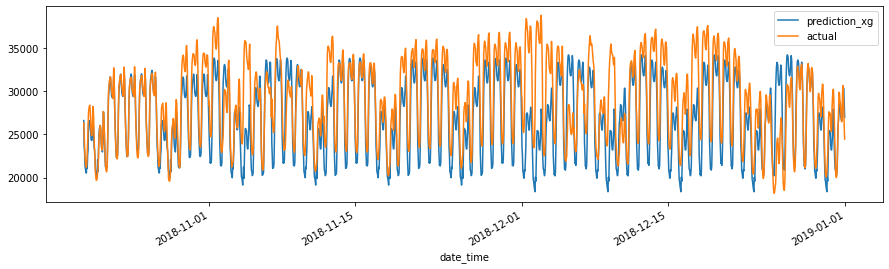

In [56]:
rmse, mape, r2 = evaluate_forecast(model_xg.predict(X_test_weighting), y_test)
mape, pe = MAPE(predictions_xg['xgb'], y_test)
predictions_xg= pd.DataFrame({'xgb' :model_xg.predict(X_test_weighting), 'date': y_test.index})
predictions_xg.set_index('date', inplace = True)
predictions_xg.plot()
y_test.plot()
plt.legend(['prediction_xg', 'actual'])
fig = plt.gcf()
fig.set_size_inches(15,4)

In [57]:
d = {'model': 'XGB','training':'Date Features Only plus exp weighting', 'testing' : 'y_test', 'RMSE' : rmse, 'MAPE': mape, 'R2': r2}
results = results.append(d, ignore_index = True)
results

C:\Users\PeterBaksh\AppData\Local\Temp\ipykernel_20628\532045351.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index = True)


,model,training,testing,RMSE,MAPE,R2
0,LR,Temperature only,y_test,4677.197549,14.007995,0.016588
1,LR,Temperature plus date features,y_test,3888.823495,10.892793,0.32017
2,XGB,Temperature plus date features,y_test,2826.03774,6.751451,0.640979
3,XGB,Date Features Only,y_test,2903.253274,7.332213,0.621092
4,XGB,Date Features Only plus exp weighting,y_test,3494.438277,7.332213,0.451068


Note in this case the exponential weighting signficantly reduced our forecast. As discussed when we initially used it this data was not a great candidate for exponential decay.

## Weighting regions of *bad data*

Lets first bring back in the data with the temperature features too

In [58]:
df['year'] = [df.index[i].year for i in range(len(df))]
df['month'] = [df.index[i].month for i in range(len(df))]
df['time'] = [int(str(df.index[i].time())[0:2]) for i in range(len(df))]
df['dayofweek'] = [df.index[i].weekday() for i in range(len(df))]
thresh = 0.95 #  95 % of the data used for training
y = df['load']
X = df.iloc[:, [1, 3, 4, 5, 6]]
X_train = X.iloc[:int(len(X) * thresh), :]
X_test = X.iloc[int(len(X) * thresh):, :]
y_train = y[:int(len(X) * thresh)]
y_test = y[int(len(X) * thresh):]
X_train.head()

,temp_mean,time,year,month,dayofweek
date_time,,,,,
2015-01-01 00:00:00,270.475,0,2015,1,3
2015-01-01 01:00:00,270.475,1,2015,1,3
2015-01-01 02:00:00,269.686,2,2015,1,3
2015-01-01 03:00:00,269.686,3,2015,1,3
2015-01-01 04:00:00,269.686,4,2015,1,3


We are now going to simulate a tubrulent period in the energy demand data between june 2016 and 2017. We are going to see how the forecast changes when this is included in our training data. This is an experiment that may seem extreme however we can then demonstrate a method to reduce the effect of regions in the training data that could be problematic

In [59]:
turbulent_start = '2016-06-01'
turbulent_end = '2017-06-01'
noise = np.random.uniform(low=-0.9, high=0.3, size=y_train.to_frame().loc[turbulent_start:turbulent_end].shape)
y_train_noise = copy.deepcopy(y_train)
y_train_noise.to_frame().loc[turbulent_start:turbulent_end] = y_train.to_frame().loc[turbulent_start:turbulent_end] + (y_train.to_frame().loc[turbulent_start:turbulent_end] * noise)


Lets visualise the period of bad data

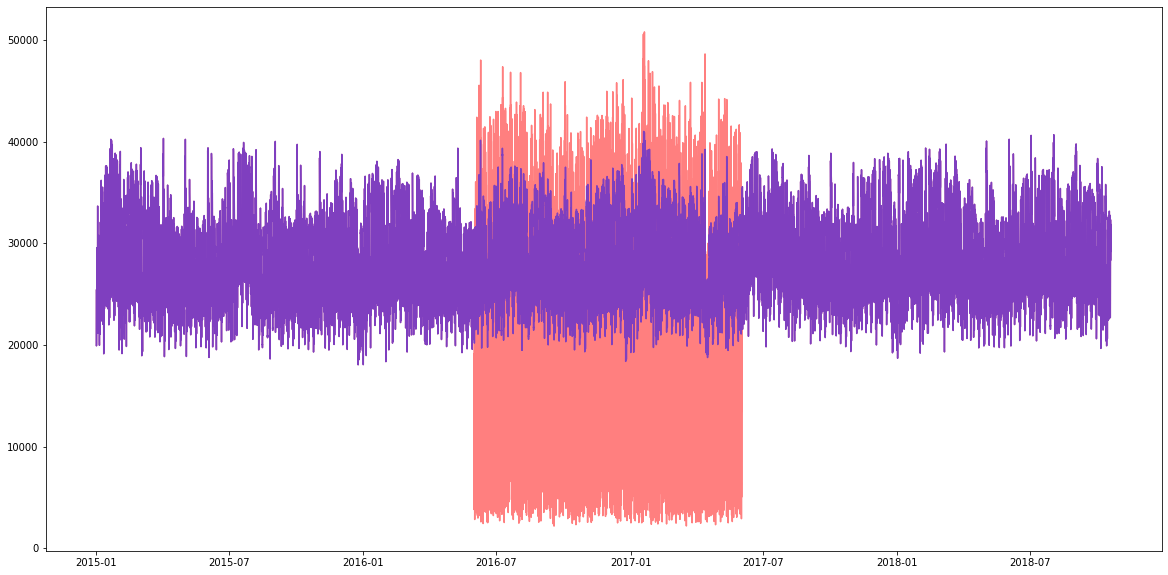

In [60]:
plt.plot(y_train_noise.index, y_train_noise.values, 'r', alpha =0.5)
plt.plot(y_train.index, y_train.values, 'b', alpha =0.5)
fig = plt.gcf()
fig.set_size_inches(20, 10)

Lets zoom in on the data

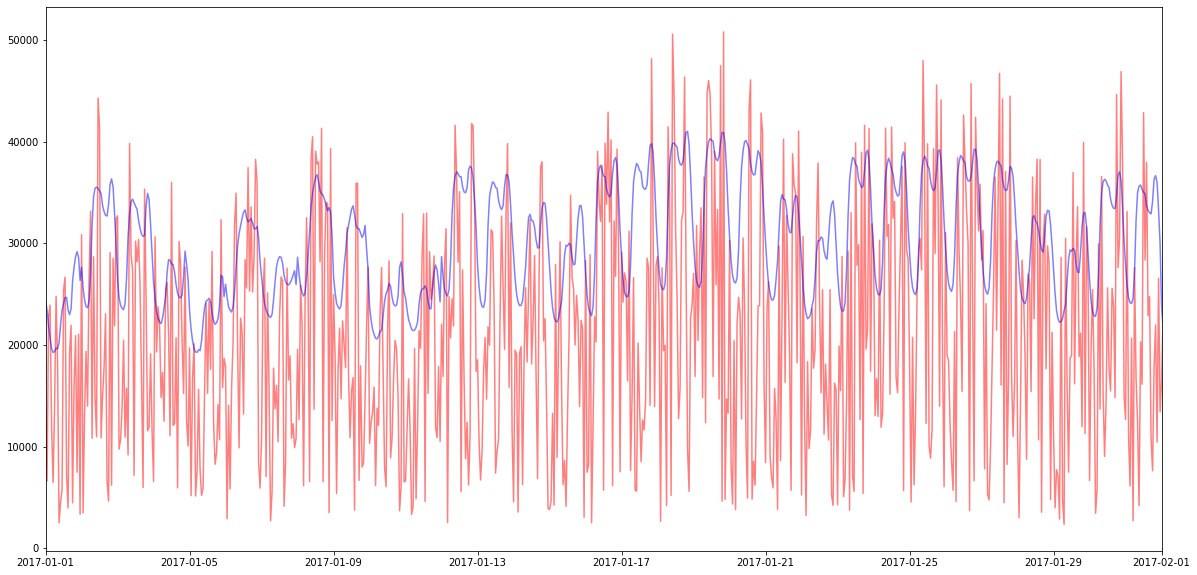

In [61]:

start_date = pd.to_datetime('2017-01-01')
end_date = pd.to_datetime('2017-02-01')

fig, ax = plt.subplots()
ax.set_xlim(start_date, end_date)
ax.plot(y_train_noise.index, y_train_noise.values, 'r', alpha=0.5)
ax.plot(y_train.index, y_train.values, 'b', alpha=0.5)
fig.set_size_inches(20, 10)
plt.show()


Lets now see how our model will be effected by training the model with our noisey data

In [62]:
model_xg = XGBRegressor()
model_xg.fit(X_train, y_train_noise)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

RMSE: 3178.82
MAPE: 8.17%
R2 Score: 0.55


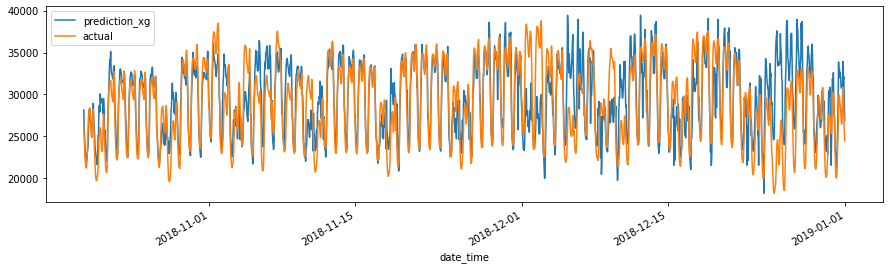

In [63]:
rmse, mape, r2 = evaluate_forecast(model_xg.predict(X_test), y_test)
mape, pe = MAPE(predictions_xg['xgb'], y_test)
predictions_xg= pd.DataFrame({'xgb' :model_xg.predict(X_test), 'date': y_test.index})
predictions_xg.set_index('date', inplace = True)
predictions_xg.plot()
y_test.plot()
plt.legend(['prediction_xg', 'actual'])
fig = plt.gcf()
fig.set_size_inches(15,4)

In [64]:
d = {'model': 'XGB','training':'Temp and Date Features with noisy year', 'testing' : 'y_test', 'RMSE' : rmse, 'MAPE': mape, 'R2': r2}
results = results.append(d, ignore_index = True)
results.drop_duplicates(inplace = True)
results


C:\Users\PeterBaksh\AppData\Local\Temp\ipykernel_20628\3170242549.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index = True)


,model,training,testing,RMSE,MAPE,R2
0,LR,Temperature only,y_test,4677.197549,14.007995,0.016588
1,LR,Temperature plus date features,y_test,3888.823495,10.892793,0.32017
2,XGB,Temperature plus date features,y_test,2826.03774,6.751451,0.640979
3,XGB,Date Features Only,y_test,2903.253274,7.332213,0.621092
4,XGB,Date Features Only plus exp weighting,y_test,3494.438277,7.332213,0.451068
5,XGB,Temp and Date Features with noisy year,y_test,3178.821765,8.963019,0.545748


In [65]:
y_test_predictions['xgb_noisy_data_temp_date'] = predictions_xg
y_test_predictions.head(1)

,load,lr_temp_only,lr-date_temp,xgb_temp_date,xgb_date,xgb_noisy_data_temp_date
date_time,,,,,,
2018-10-19 23:00:00,26331.0,28844.613053,32115.512704,27531.595703,27835.466797,28139.587891


So we see a drop due to the turbulent period. Lets now add a column to deal with that as a bad year. We are now going to add a proxy column to indicate the region that we think could be bad data

In [66]:
X_train_new = X_train.copy()
turbulent_index = (X_train_new.index >= turbulent_start) & (X_train_new.index <= turbulent_end)
X_train_new.loc[turbulent_index, 'bad_date'] = 0
X_train_new.loc[~turbulent_index, 'bad_date'] = 1


In [67]:
X_train_new.head()

,temp_mean,time,year,month,dayofweek,bad_date
date_time,,,,,,
2015-01-01 00:00:00,270.475,0,2015,1,3,1.0
2015-01-01 01:00:00,270.475,1,2015,1,3,1.0
2015-01-01 02:00:00,269.686,2,2015,1,3,1.0
2015-01-01 03:00:00,269.686,3,2015,1,3,1.0
2015-01-01 04:00:00,269.686,4,2015,1,3,1.0


<AxesSubplot:xlabel='date_time'>

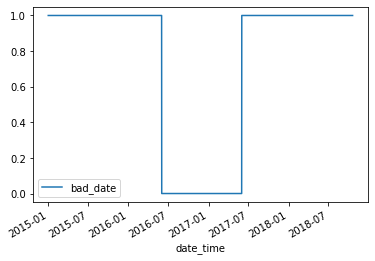

In [68]:
X_train_new.plot(y = 'bad_date')

In [69]:
model_xg = XGBRegressor()
model_xg.fit(X_train_new, y_train_noise)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Now we make a prediction

In [70]:
X_test_new = copy.deepcopy(X_test)
X_test_new['bad_date'] = [1] * len(X_test)

RMSE: 2757.91
MAPE: 6.82%
R2 Score: 0.66


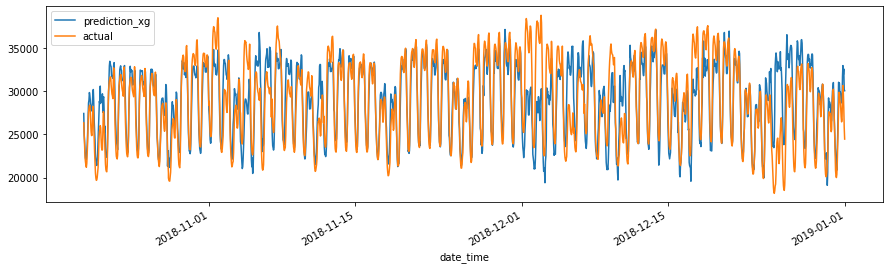

In [71]:
rmse, mape, r2 = evaluate_forecast(model_xg.predict(X_test_new), y_test)
mape, pe = MAPE(predictions_xg['xgb'], y_test)
predictions_xg= pd.DataFrame({'xgb' :model_xg.predict(X_test_new), 'date': y_test.index})
predictions_xg.set_index('date', inplace = True)
predictions_xg.plot()
y_test.plot()
plt.legend(['prediction_xg', 'actual'])
fig = plt.gcf()
fig.set_size_inches(15,4)

In [72]:
d = {'model': 'XGB','training':'Temp +Date Features + bad date column with noisy year', 'testing' : 'y_test', 'RMSE' : rmse, 'MAPE': mape, 'R2': r2}
results = results.append(d, ignore_index = True)
results


C:\Users\PeterBaksh\AppData\Local\Temp\ipykernel_20628\2637658717.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index = True)


,model,training,testing,RMSE,MAPE,R2
0,LR,Temperature only,y_test,4677.197549,14.007995,0.016588
1,LR,Temperature plus date features,y_test,3888.823495,10.892793,0.32017
2,XGB,Temperature plus date features,y_test,2826.03774,6.751451,0.640979
3,XGB,Date Features Only,y_test,2903.253274,7.332213,0.621092
4,XGB,Date Features Only plus exp weighting,y_test,3494.438277,7.332213,0.451068
5,XGB,Temp and Date Features with noisy year,y_test,3178.821765,8.963019,0.545748
6,XGB,Temp +Date Features + bad date column with noi...,y_test,2757.914444,8.171902,0.658079


In [73]:
y_test_predictions['xgb_noisy_data_date_temp_proxy_column'] = predictions_xg
y_test_predictions.head(3)

,load,lr_temp_only,lr-date_temp,xgb_temp_date,xgb_date,xgb_noisy_data_temp_date,xgb_noisy_data_date_temp_proxy_column
date_time,,,,,,,
2018-10-19 23:00:00,26331.0,28844.613053,32115.512704,27531.595703,27835.466797,28139.587891,27418.228516
2018-10-20 00:00:00,24963.0,28844.613053,23860.727388,24318.933594,23581.941406,26136.042969,24968.816406
2018-10-20 01:00:00,23395.0,28844.613053,24200.155626,22746.380859,22185.484375,24833.314453,24180.539062


The effect of the noisy year in our training data has now been reduced. To what degree will vary since there is some randomness to XGboost. We can see the reason why in the feature importance below

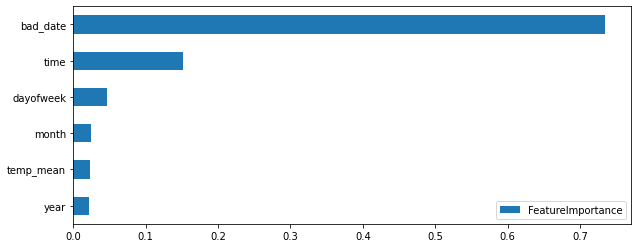

In [74]:
feat_imp_dict = dict(zip(X_train_new.columns, model_xg.feature_importances_))
feat_imp = pd.DataFrame.from_dict(feat_imp_dict, orient='index')
feat_imp.rename(columns = {0:'FeatureImportance'}, inplace = True)
feat_imp.query('FeatureImportance>0').sort_values(by=['FeatureImportance']).plot.barh();
fig = plt.gcf()
fig.set_size_inches(10, 4)

## Automatically identifying points that may not be representivie of the forecast.

In some cases you may have a specific region that is problematic in your data. For example Covid years in a time series forecast you may want trained under different conditions to times prior to covid. However in other time series you get random spikes that you dont think are predictiable and therefore want to discourage your model from *learning* from them. As with the previous analysis we can introduce a proxy column to indicate where these values could be in the training data. 


(17683.0, 17744.0)

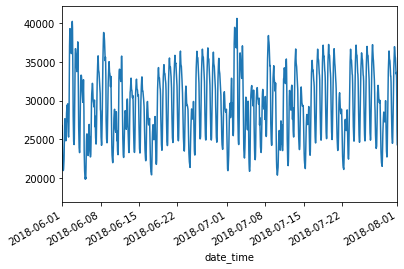

In [75]:
y_train.plot()
plt.xlim([pd.to_datetime('2018-06-01'), pd.to_datetime('2018-08-01')])


We are going to do this based on standard deviations. For points in the training data that are outside of 2 standard deviates of the data in the last 10 days we shall label these as outliars. For otherpoints we shall label them as normal. Lets look how our data lies inside within these standard deviatations 

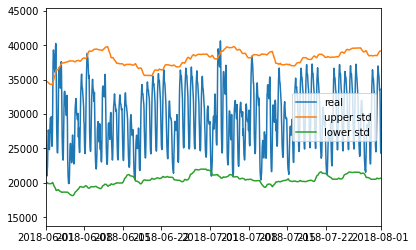

In [76]:
rolling_std = y_train.rolling(window=int(10*24)).std().to_frame()
rolling_mean = y_train.rolling(window=int(10*24)).mean().to_frame()
rolling_std = rolling_std.dropna()
rolling_mean = rolling_mean.dropna()

plt.plot(y_train.index, y_train.values)
plt.plot(rolling_std.index, rolling_mean.values + 2 *rolling_std.values )
plt.plot(rolling_std.index, rolling_mean.values - 2 *rolling_std.values )
plt.xlim([pd.to_datetime('2018-06-01'), pd.to_datetime('2018-08-01')])
plt.legend(['real', 'upper std', 'lower std'])

99.7% of points will sit inside 3 standard deviations


As an experiment for random large fluctuations I am going to add some large random spikes to the data

In [77]:

spike_indices = np.random.randint(0, len(y_train), size=len(y_train)//25)
spike_values = np.random.normal(loc=1.5*y_train.mean(), scale=y_train.std(), size=len(spike_indices))
# add spikes to the time series
y_train_spike = y_train.copy()
y_train_spike.iloc[spike_indices] = spike_values



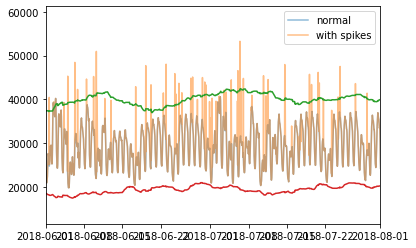

In [78]:
plt.plot(y_train.index, y_train.values, alpha = 0.5)
plt.plot(y_train.index, y_train_spike.values, alpha = 0.5)
rolling_std = y_train_spike.rolling(window=int(10*24)).std().to_frame()
rolling_mean = y_train_spike.rolling(window=int(10*24)).mean().to_frame()
rolling_std = rolling_std.dropna()
rolling_mean = rolling_mean.dropna()
plt.plot(rolling_std.index, rolling_mean.values + 2 *rolling_std.values )
plt.plot(rolling_std.index, rolling_mean.values - 2 *rolling_std.values )
plt.xlim([pd.to_datetime('2018-06-01'), pd.to_datetime('2018-08-01')])
plt.legend(['real', 'upper std', 'lower std'])
plt.legend(['normal', 'with spikes'])
# fig = plt.gcf()
# fig.set_size_inches(20, 7)

Here we can see the noisy points. Lets train our regression algorithm again with this spikey training data noting we get an RMSE of 2826 when we have our normal data. We expect to see this RMSE to reduce when we train on this data. 

In [79]:
model_xg = XGBRegressor()
model_xg.fit(X_train, y_train_spike)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

RMSE: 2992.42
MAPE: 7.78%
R2 Score: 0.60


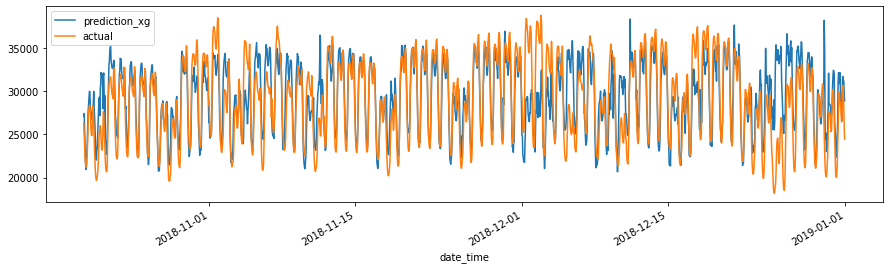

In [80]:
rmse, mape, r2 = evaluate_forecast(model_xg.predict(X_test), y_test)
mape, pe = MAPE(predictions_xg['xgb'], y_test)
predictions_xg= pd.DataFrame({'xgb' :model_xg.predict(X_test), 'date': y_test.index})
predictions_xg.set_index('date', inplace = True)
predictions_xg.plot()
y_test.plot()
plt.legend(['prediction_xg', 'actual'])
fig = plt.gcf()
fig.set_size_inches(15,4)

As expected we see the metrics reduce. Lets see if we can recover these metrics by adding a column that lets the regression know we want to exclude these outliars

In [81]:
d = {'model': 'XGB','training':'Temp and Date Features with spikes', 'testing' : 'y_test', 'RMSE' : rmse, 'MAPE': mape, 'R2': r2}
results = results.append(d, ignore_index = True)
results


C:\Users\PeterBaksh\AppData\Local\Temp\ipykernel_20628\934292075.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index = True)


,model,training,testing,RMSE,MAPE,R2
0,LR,Temperature only,y_test,4677.197549,14.007995,0.016588
1,LR,Temperature plus date features,y_test,3888.823495,10.892793,0.32017
2,XGB,Temperature plus date features,y_test,2826.03774,6.751451,0.640979
3,XGB,Date Features Only,y_test,2903.253274,7.332213,0.621092
4,XGB,Date Features Only plus exp weighting,y_test,3494.438277,7.332213,0.451068
5,XGB,Temp and Date Features with noisy year,y_test,3178.821765,8.963019,0.545748
6,XGB,Temp +Date Features + bad date column with noi...,y_test,2757.914444,8.171902,0.658079
7,XGB,Temp and Date Features with spikes,y_test,2992.417137,6.81533,0.597461


Note here that the presence of the data with spikes in the training data has reduced our predictive power where the R2 on the test data has reduced. Below we are going to identify the points that lie outside 2 STDs of the data as 1 and 0 for all other points

In [82]:
rolling_mean = y_train_spike.rolling(window=int(10*24)).mean()
rolling_std = y_train_spike.rolling(window=int(10*24)).std()

upper_bound = rolling_mean + 2 * rolling_std
lower_bound = rolling_mean - 2 * rolling_std

values = np.where((y_train_spike < upper_bound) | (y_train_spike < lower_bound), 0, 1)

X_train_spike = copy.deepcopy(X_train)
X_train_spike['spikes'] = values
X_test_spike = copy.deepcopy(X_test)
X_test_spike['spikes'] = [0] * len(X_test)

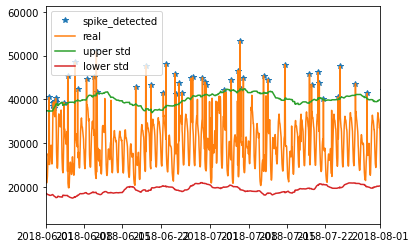

In [83]:
# values = np.where((y_train_spike < upper_bound) & (y_train_spike > lower_bound), 0,  1/np.abs(y_train_spike - rolling_mean + 1))
plt.plot(y_train_spike.index[X_train_spike.spikes ==1], y_train_spike.values[X_train_spike.spikes ==1], '*')
plt.plot(y_train_spike.index, y_train_spike.values)
plt.plot(rolling_std.index, rolling_mean.values + 2 *rolling_std.values )
plt.plot(rolling_std.index, rolling_mean.values - 2 *rolling_std.values )
plt.xlim([pd.to_datetime('2018-06-01'), pd.to_datetime('2018-08-01')])
plt.legend(['spike_detected', 'real', 'upper std', 'lower std'])


In [84]:
X_train_spike = copy.deepcopy(X_train)
X_train_spike['spikes'] = values
X_test_spike = copy.deepcopy(X_test)
X_test_spike['spikes'] = [0] * len(X_test)

In [85]:
X_train_spike.sample(20)

,temp_mean,time,year,month,dayofweek,spikes
date_time,,,,,,
2017-08-20 12:00:00,300.150,12,2017,8,6,0
2015-07-18 15:00:00,305.650,15,2015,7,5,0
2017-09-07 05:00:00,295.150,5,2017,9,3,0
2017-06-08 06:00:00,292.150,6,2017,6,3,0
2015-11-28 14:00:00,295.150,14,2015,11,5,0
2017-06-16 20:00:00,303.150,20,2017,6,4,0
2017-05-19 23:00:00,291.150,23,2017,5,4,0
2017-08-18 02:00:00,299.150,2,2017,8,4,0
2017-12-08 20:00:00,288.150,20,2017,12,4,0


We shall now re train our model using the column that labels random spikes 

In [86]:
model_xg = XGBRegressor()
model_xg.fit(X_train_spike, y_train_spike)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

RMSE: 2805.60
MAPE: 6.81%
R2 Score: 0.65


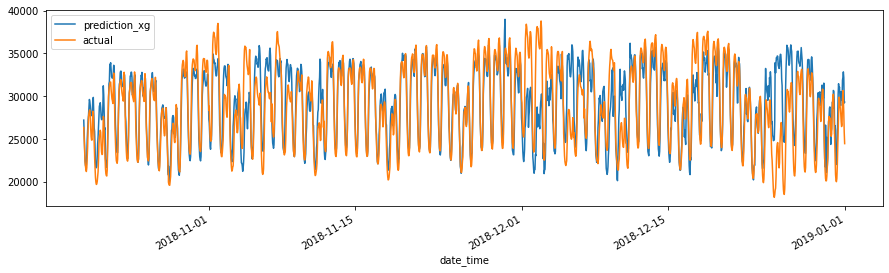

In [87]:
rmse, mape, r2 = evaluate_forecast(model_xg.predict(X_test_spike), y_test)
mape, pe = MAPE(predictions_xg['xgb'], y_test)
predictions_xg= pd.DataFrame({'xgb' :model_xg.predict(X_test_spike), 'date': y_test.index})
predictions_xg.set_index('date', inplace = True)
predictions_xg.plot()
y_test.plot()
plt.legend(['prediction_xg', 'actual'])
fig = plt.gcf()
fig.set_size_inches(15,4)

In [88]:
d = {'model': 'XGB','training':'Temp and Date Features with automatic spike column. spike data', 'testing' : 'y_test', 'RMSE' : rmse, 'MAPE': mape, 'R2': r2}
results = results.append(d, ignore_index = True)
results


C:\Users\PeterBaksh\AppData\Local\Temp\ipykernel_20628\1099171129.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index = True)


,model,training,testing,RMSE,MAPE,R2
0,LR,Temperature only,y_test,4677.197549,14.007995,0.016588
1,LR,Temperature plus date features,y_test,3888.823495,10.892793,0.32017
2,XGB,Temperature plus date features,y_test,2826.03774,6.751451,0.640979
3,XGB,Date Features Only,y_test,2903.253274,7.332213,0.621092
4,XGB,Date Features Only plus exp weighting,y_test,3494.438277,7.332213,0.451068
5,XGB,Temp and Date Features with noisy year,y_test,3178.821765,8.963019,0.545748
6,XGB,Temp +Date Features + bad date column with noi...,y_test,2757.914444,8.171902,0.658079
7,XGB,Temp and Date Features with spikes,y_test,2992.417137,6.81533,0.597461
8,XGB,Temp and Date Features with automatic spike co...,y_test,2805.598665,7.783906,0.646153


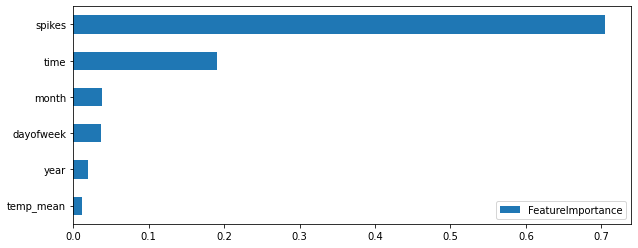

In [89]:
feat_imp_dict = dict(zip(X_train_spike.columns, model_xg.feature_importances_))
feat_imp = pd.DataFrame.from_dict(feat_imp_dict, orient='index')
feat_imp.rename(columns = {0:'FeatureImportance'}, inplace = True)
feat_imp.query('FeatureImportance>0').sort_values(by=['FeatureImportance']).plot.barh();
fig = plt.gcf()
fig.set_size_inches(10, 4)

As before we can see the effect of our proxy column that is automaitcally identifying when there is a possible outliars and telling the regression it should consider ignoring these values should help in improving our forecast

## Conclusion

This notebook is an introduction to using regression methods for time series forecasting. They key points are creating time features and it is likely a non -linear model will help with any seasonality. It is easy to include exogenous variables that are likely to improve the forecast if chosen carefully. 

For more infomation on time series forecasting using regression then the following links are helpful

https://github.com/zgana/fpp3-python-readalong/blob/master/10-Dynamic-regression-models.ipynb

https://otexts.com/fpp3/dynamic.html